In [30]:
import numpy as np

def crossover_cx(size, p1, p2):
    positions = np.arange(size, dtype=int)
    order1 = np.argsort(p1)
    child1 = np.zeros(size, dtype=int)
    child2 = np.zeros(size, dtype=int)

    inplace = p1 == p2
    child1[inplace] = p1[inplace]
    child2[inplace] = p2[inplace]
    positions[inplace] = -1
    
    cycle_nbr = 0
    while np.any(positions != -1):
        cycle = [np.argmax(positions > -1)]

        while p1[cycle[0]] != p2[cycle[-1]]:
            step = p2[cycle[-1]]
            pos = order1[step]
            cycle.append(pos)
        
        print(positions, cycle)
        positions[cycle] = -1
        if cycle_nbr % 2 == 0:
            child1[cycle] = p1[cycle]
            child2[cycle] = p2[cycle]
        else:
            child1[cycle] = p2[cycle]
            child2[cycle] = p1[cycle]
        cycle_nbr += 1

    return child1, child2

p1 = np.array([1, 3, 7, 0, 5, 2, 6, 4, 8])
p2 = np.array([0, 2, 4, 6, 8, 1, 3, 5, 7])
child1, child2 = crossover_cx(9, p1, p2)
print(child1)
print(child2)


In [38]:
import graph_tool.all as gt
from packing_coloring.graph_generator import *
from packing_coloring.utils import *
from packing_coloring.algorithms.problem import *

from packing_coloring.algorithms.constructive.greedy_algo import *
from packing_coloring.algorithms.constructive.rlf_algo import *
from packing_coloring.algorithms.constructive.swo_algo import *
from packing_coloring.algorithms.perturbative.hybrid_algo import *
from packing_coloring.algorithms.perturbative.tabupackcol import *

import numpy as np
import pandas as pd
import igraph
np.set_printoptions(threshold=np.nan)

from IPython.html.widgets import interactive
from IPython.display import display
from os import listdir
from os.path import join, isfile
from pylab import get_cmap

In [2]:
def area_score(prob, sol):
    max_pack = sol.get_max_col()+1
    scores = np.zeros(max_pack, dtype=float)
    for col in np.arange(1, max_pack):
        kcol_nodes = sol == col
        dist_mat = prob.dist_matrix.A
        kcol_dist = dist_mat[kcol_nodes]

        first_half = np.floor(col/2)
        half_nodes = kcol_dist <= first_half
        half_nodes[kcol_dist == 0] = False
        area_score = np.sum(half_nodes)

        if col % 2 == 1:
            border = np.ceil(col/2)
            for x in np.arange(prob.v_size)[kcol_nodes]:
                x_dist = dist_mat[x]
                border_nodes = (x_dist == border)
                x = np.arange(prob.v_size)[x_dist==0]
                x_half_nodes = (x_dist == first_half)
                
                for y in np.arange(prob.v_size)[border_nodes]:
                    y_neighbors = (prob.dist_matrix[y] == 1).A1
                    common = np.logical_and(y_neighbors, x_half_nodes)
                    area_score += float(np.sum(common))/np.sum(y_neighbors)
        scores[col] = (area_score)/np.sum(kcol_nodes)

    return scores

In [28]:
g = gt.lattice([4, 4])
dist_mat = get_distance_matrix(g)
prob = GraphProblem(dist_mat)

In [29]:
sol = rlf_algorithm(prob)
score = sol.get_area_score(prob)
print(sol)
print(score)

[1 3 1 2 2 1 4 1 1 5 1 3 3 1 2 1]
0.120903805497


In [37]:
print(np.abs(1-sol.get_k_area(prob, 1)/1))
print(sol.get_k_area(prob, 2)/2)
print(sol.get_k_area(prob, 3)/3)

1.25
1.5
1.5


In [35]:
sol[:] = [2, 1, 3, 1, 4, 1, 3, 1, 2]
score = sol.get_area_score(prob)
print(score)

0.111111111111


In [36]:
print(sol.get_k_area(prob, 1)/1)
print(sol.get_k_area(prob, 2)/2)
print(sol.get_k_area(prob, 3)/3)

2.25
1.5
1.5


In [9]:
sol[:] = [1, 1, 1, 1, 1, 4, 2, 2, 2]
score = sol.get_area_score(prob)
print(score)

0.0653395784543


In [47]:
def mutation(prob, sol):
    diam = prob.get_diam()
    bounds = np.zeros(prob.v_size, dtype=int)
    for i in range(sol.v_size):
        i_col = min(sol[i], diam - 1) + 1
        bound = np.sum(prob.dist_matrix[i] == i_col)
        bounds[i] = bound

    v = np.argmax(bounds)
    v_col = min(sol[v], diam - 1) + 1
    adj_mat = (prob.dist_matrix == 1)
    changes = np.logical_or((prob.dist_matrix[v] == v_col), adj_mat[v])
    adj_mat[v] = changes
    adj_mat[..., v] = np.transpose(changes)
    new_prob = GraphProblem(adj_mat)
    return new_prob

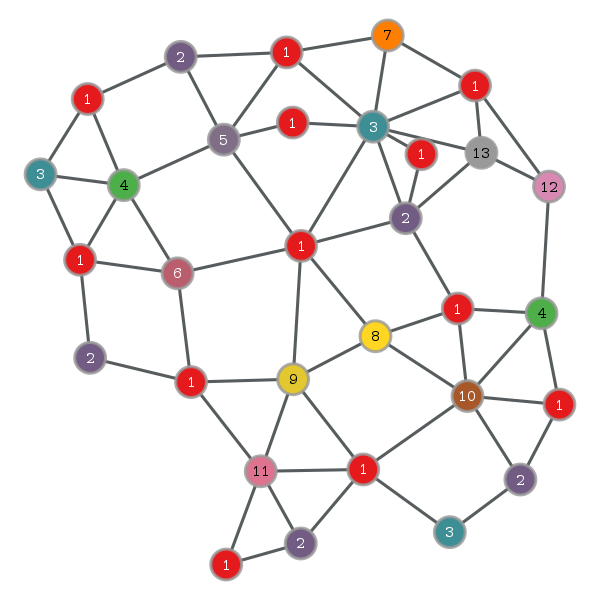

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fb1d426c710, at 0x7fb1d4264cf8>

In [45]:
g = gt.load_graph("instances/dot_format/random.dot")
dist_mat = get_distance_matrix(g)
prob = GraphProblem(dist_mat)
sol = rlf_algorithm(prob)

pos = gt.sfdp_layout(g, cooling_step=0.95, epsilon=1e-2)
max_col = sol.get_max_col()
col = [c/max_col for c in sol]
col_v = g.new_vertex_property("float")
col_v.a = np.array(col)

text_v = g.new_vertex_property("int")
text_v.a = sol.pack_col.astype(int)

gt.graph_draw(g, pos=pos, vertex_text=text_v, vertex_font_size=14, vertex_fill_color=col_v, vcmap=get_cmap("Set1"), inline=True)


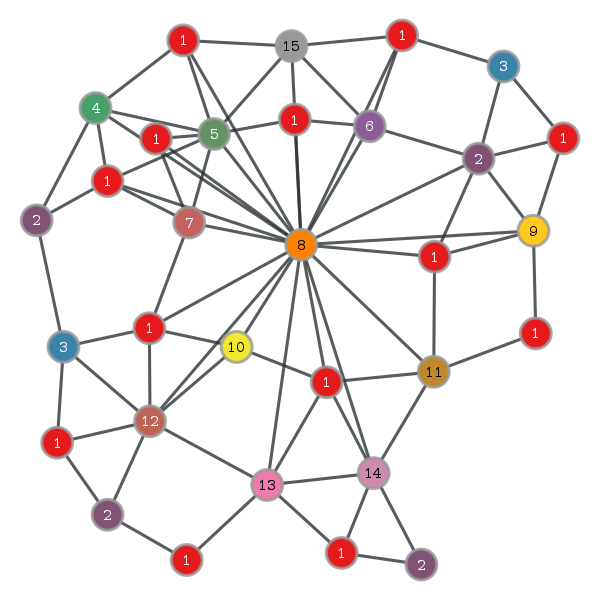

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fb1d426c710, at 0x7fb1d4264c50>

In [48]:
new_prob = mutation(prob, sol)
new_sol = rlf_algorithm(new_prob)

new_g = graph_from_dist(new_prob.dist_matrix)
pos = gt.sfdp_layout(g, cooling_step=0.95, epsilon=1e-2)
max_col = new_sol.get_max_col()
col = [c/max_col for c in new_sol]
col_v = new_g.new_vertex_property("float")
col_v.a = np.array(new_sol)

text_v = new_g.new_vertex_property("int")
text_v.a = new_sol.pack_col.astype(int)

gt.graph_draw(new_g, pos=pos, vertex_text=text_v, vertex_font_size=14, vertex_fill_color=col_v, vcmap=get_cmap("Set1"), inline=True)


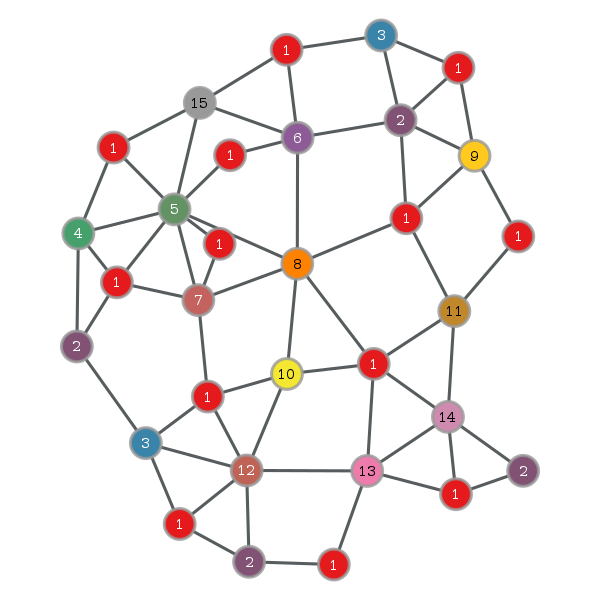

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fb1d426c710, at 0x7fb1d4275b70>

In [49]:
sol2 = greedy_algorithm(prob, new_sol.get_greedy_order())

pos = gt.sfdp_layout(g, cooling_step=0.95, epsilon=1e-2)
max_col = sol2.get_max_col()
col = [c/max_col for c in sol2]
col_v = g.new_vertex_property("float")
col_v.a = np.array(col)

text_v = g.new_vertex_property("int")
text_v.a = sol2.pack_col.astype(int)

gt.graph_draw(g, pos=pos, vertex_text=text_v, vertex_font_size=14, vertex_fill_color=col_v, vcmap=get_cmap("Set1"), inline=True)